In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import datetime

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
df = pd.read_csv('./data/order_data_days.csv',parse_dates=['Order Date'],index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2019-04-19 to 2020-08-30
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Total Count  500 non-null    int64
dtypes: int64(1)
memory usage: 7.8 KB


In [5]:
df

,Total Count
Order Date,
2019-04-19,51
2019-04-20,57
2019-04-21,46
2019-04-22,51
2019-04-23,55
...,...
2020-08-26,46
2020-08-27,49
2020-08-28,42


<AxesSubplot:xlabel='Order Date'>

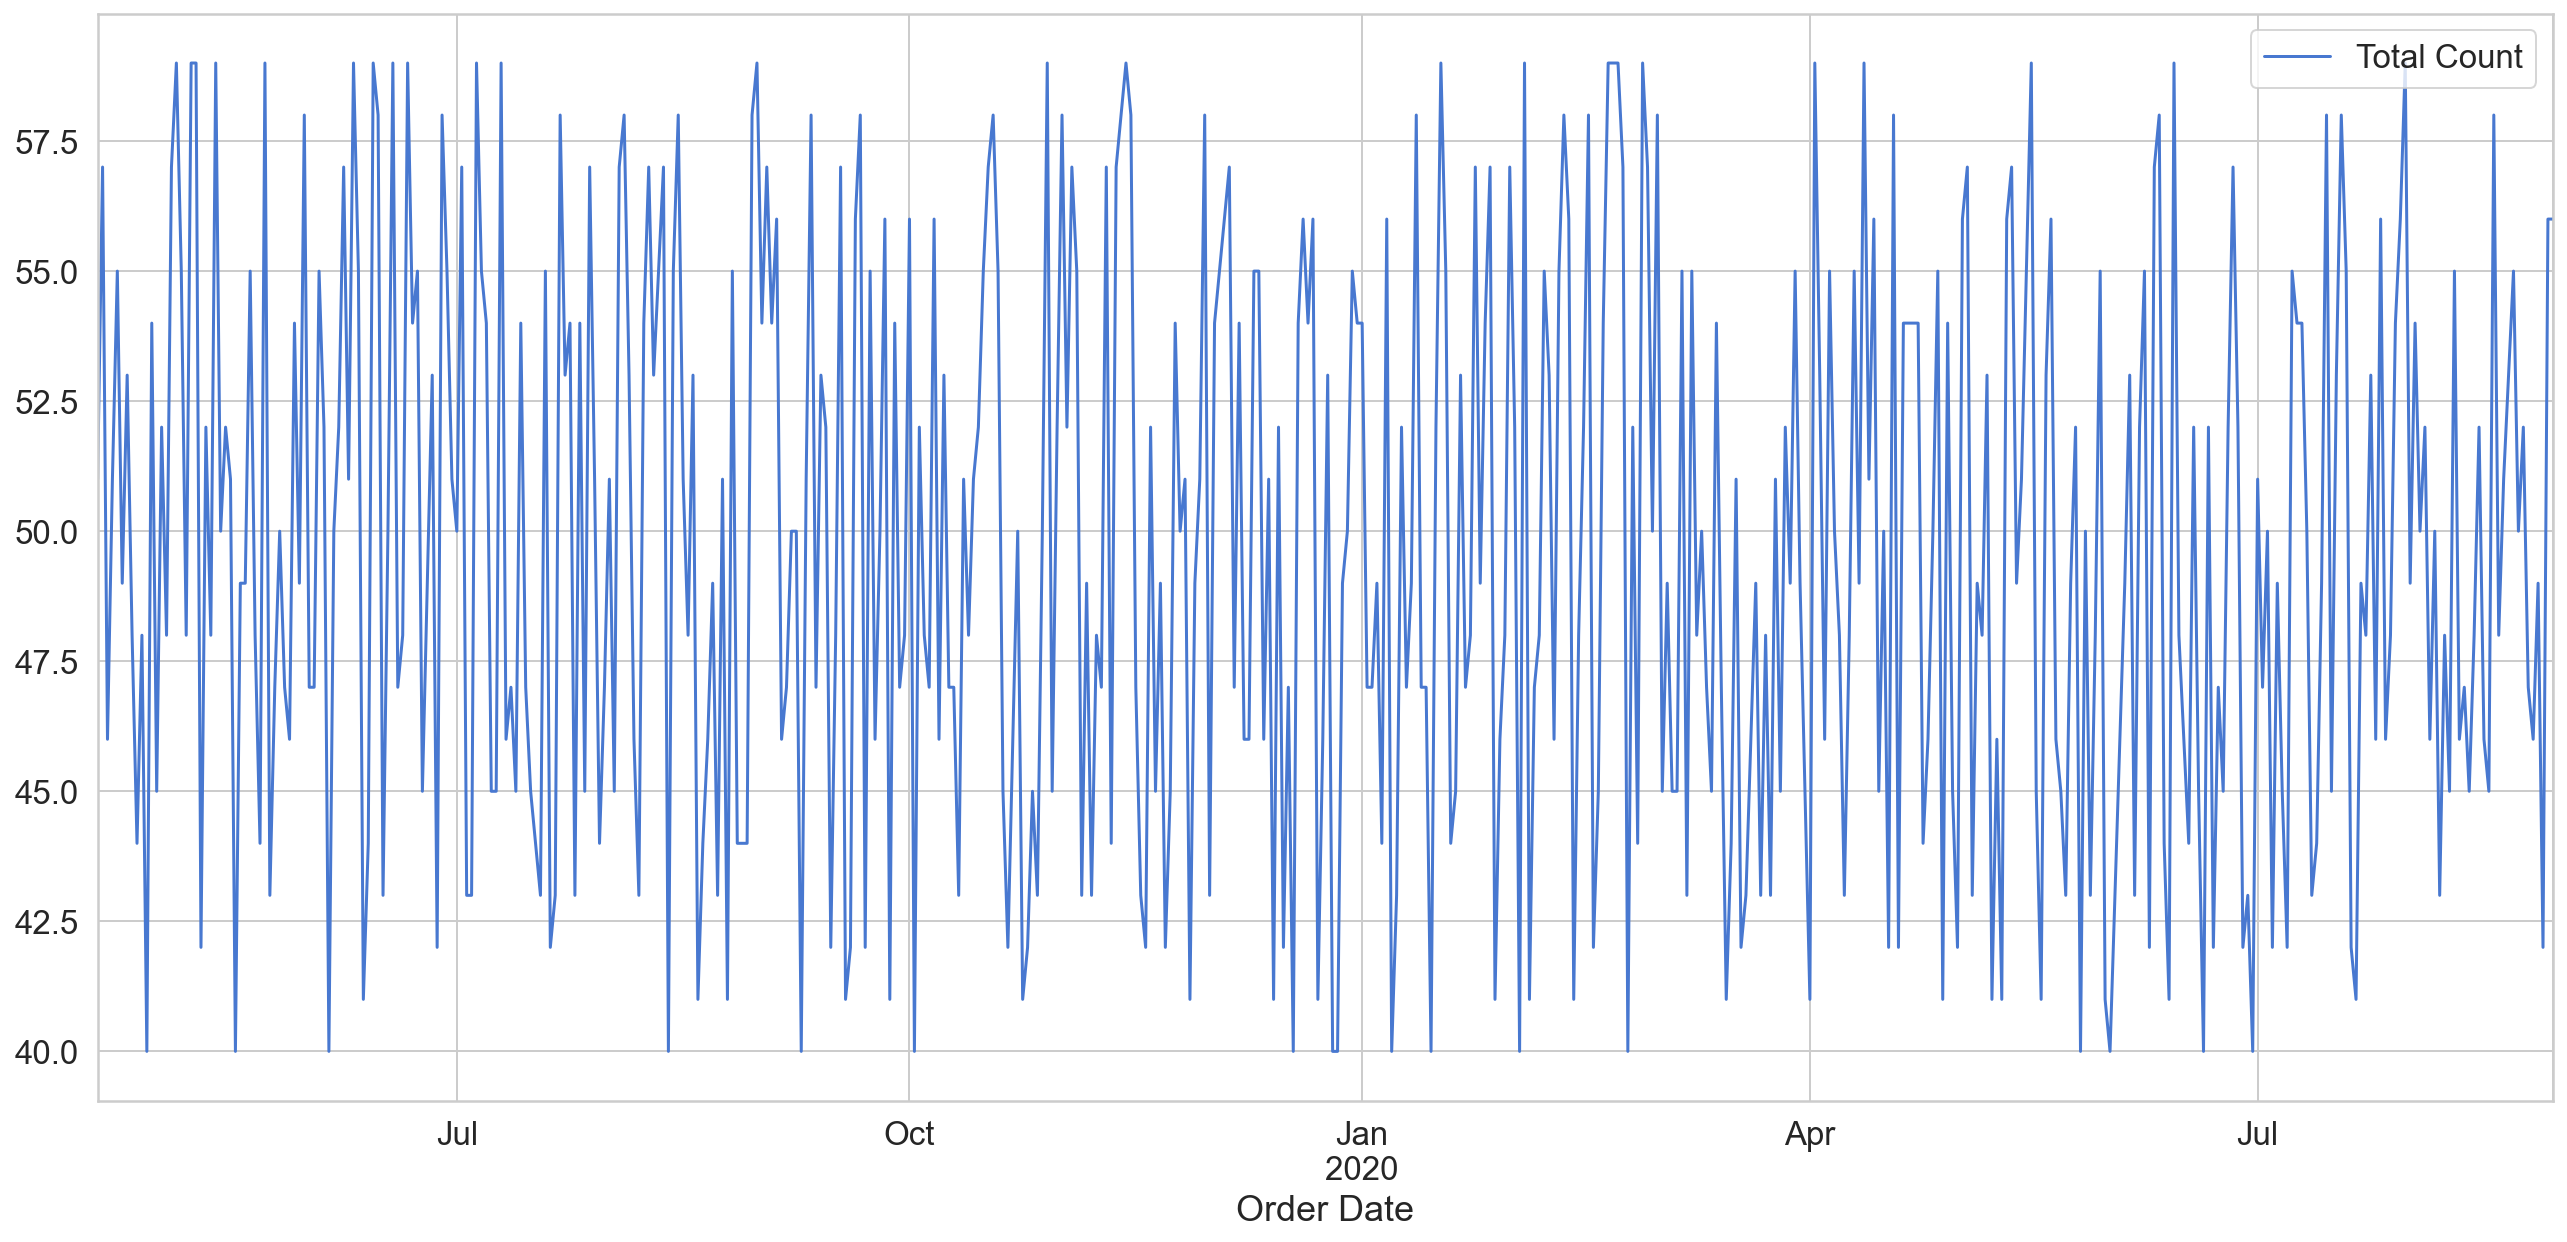

In [6]:
df.plot(y="Total Count")

In [7]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

400 100


In [8]:
f_columns = ['Total Count']

scaler = MinMaxScaler(feature_range=(0,1))

scaler = scaler.fit(train[f_columns].to_numpy())

train.loc[:, f_columns] = scaler.transform(train[f_columns].to_numpy())

test.loc[:, f_columns] = scaler.transform(test[f_columns].to_numpy())

In [9]:
train

,Total Count
Order Date,
2019-04-19,0.578947
2019-04-20,0.894737
2019-04-21,0.315789
2019-04-22,0.578947
2019-04-23,0.789474
...,...
2020-05-18,0.052632
2020-05-19,0.684211
2020-05-20,0.842105


In [10]:
test

,Total Count
Order Date,
2020-05-23,0.157895
2020-05-24,0.473684
2020-05-25,0.631579
2020-05-26,0.000000
2020-05-27,0.526316
...,...
2020-08-26,0.315789
2020-08-27,0.473684
2020-08-28,0.105263


In [11]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences.iloc[i:end_ix, :].values, sequences.iloc[end_ix:out_end_ix, :].values
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [12]:
n_steps_in, n_steps_out = 28, 7

X_train, y_train = split_sequences(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequences(test, n_steps_in, n_steps_out)

# the dataset knows the number of features.
n_features = X_train.shape[2]

n_features

1

In [13]:
X_train.shape

(366, 28, 1)

In [14]:
y_train.shape

(366, 7, 1)

In [15]:
X_test.shape

(66, 28, 1)

In [16]:
y_test.shape

(66, 7, 1)

In [17]:
# define model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(500, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(tf.keras.layers.RepeatVector(n_steps_out))
model.add(tf.keras.layers.LSTM(500, activation='relu', return_sequences=True))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features)))

adem=tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=adem, loss='mse')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500)               1004000   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 500)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 500)            2002000   
_________________________________________________________________
dropout (Dropout)            (None, 7, 500)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 1)              501       
Total params: 3,006,501
Trainable params: 3,006,501
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train, epochs=300, batch_size=5,validation_split=0.3)

300
256/256 [==============================] - 22s 86ms/sample - loss: 0.0741 - val_loss: 0.1135
Epoch 115/300
256/256 [==============================] - 22s 86ms/sample - loss: 0.0734 - val_loss: 0.1089
Epoch 116/300
256/256 [==============================] - 22s 87ms/sample - loss: 0.0761 - val_loss: 0.1161
Epoch 117/300
256/256 [==============================] - 22s 87ms/sample - loss: 0.0736 - val_loss: 0.1047
Epoch 118/300
256/256 [==============================] - 23s 89ms/sample - loss: 0.0733 - val_loss: 0.1016
Epoch 119/300
256/256 [==============================] - 22s 86ms/sample - loss: 0.0748 - val_loss: 0.1076
Epoch 120/300
256/256 [==============================] - 22s 86ms/sample - loss: 0.0718 - val_loss: 0.1096
Epoch 121/300
256/256 [==============================] - 22s 86ms/sample - loss: 0.0728 - val_loss: 0.1075
Epoch 122/300
256/256 [==============================] - 22s 86ms/sample - loss: 0.0718 - val_loss: 0.1035
Epoch 123/300
256/256 [========================

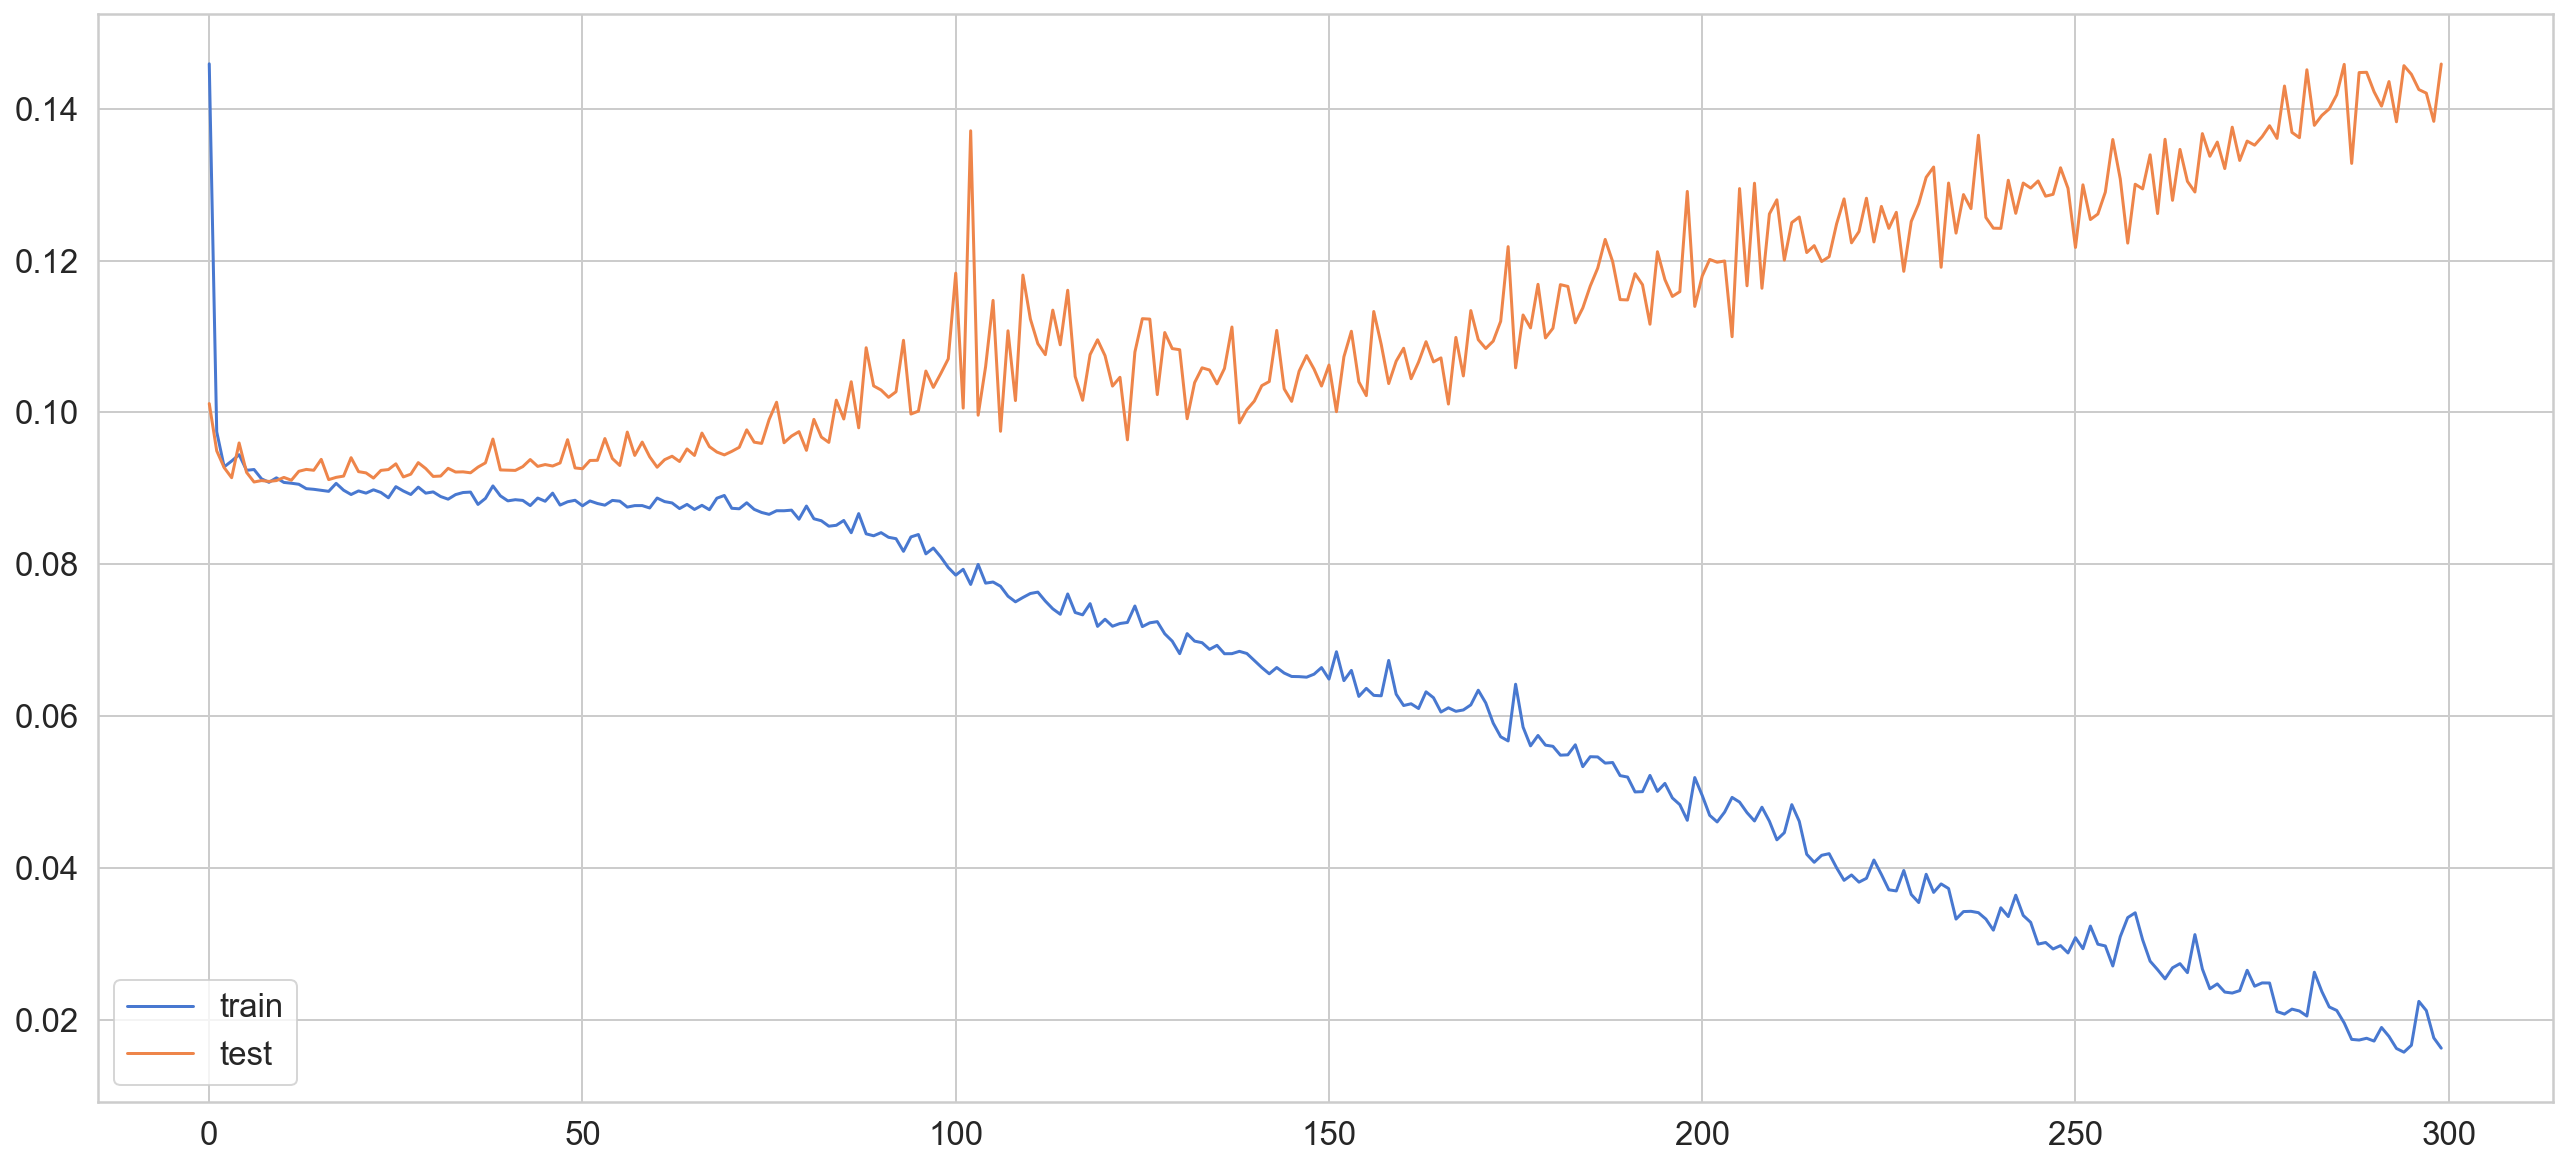

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [21]:
y_pred = model.predict(X_test) 

In [22]:
def inverse_transform(arr):
    a=[]
    for i in arr:
        b=scaler.inverse_transform(i)
        a.append(b.tolist())
    return np.array(a)

In [23]:
X_test_inv = inverse_transform(X_test)
y_test_inv = inverse_transform(y_test)
y_pred_inv = inverse_transform(y_pred)

In [24]:
y_test_inv[0]

array([[40.],
       [52.],
       [42.],
       [47.],
       [45.],
       [52.],
       [57.]])

In [25]:
y_pred_inv[0]

array([[47.44810486],
       [48.93906021],
       [48.66279221],
       [51.56954193],
       [55.24095535],
       [51.71090317],
       [43.06330109]])

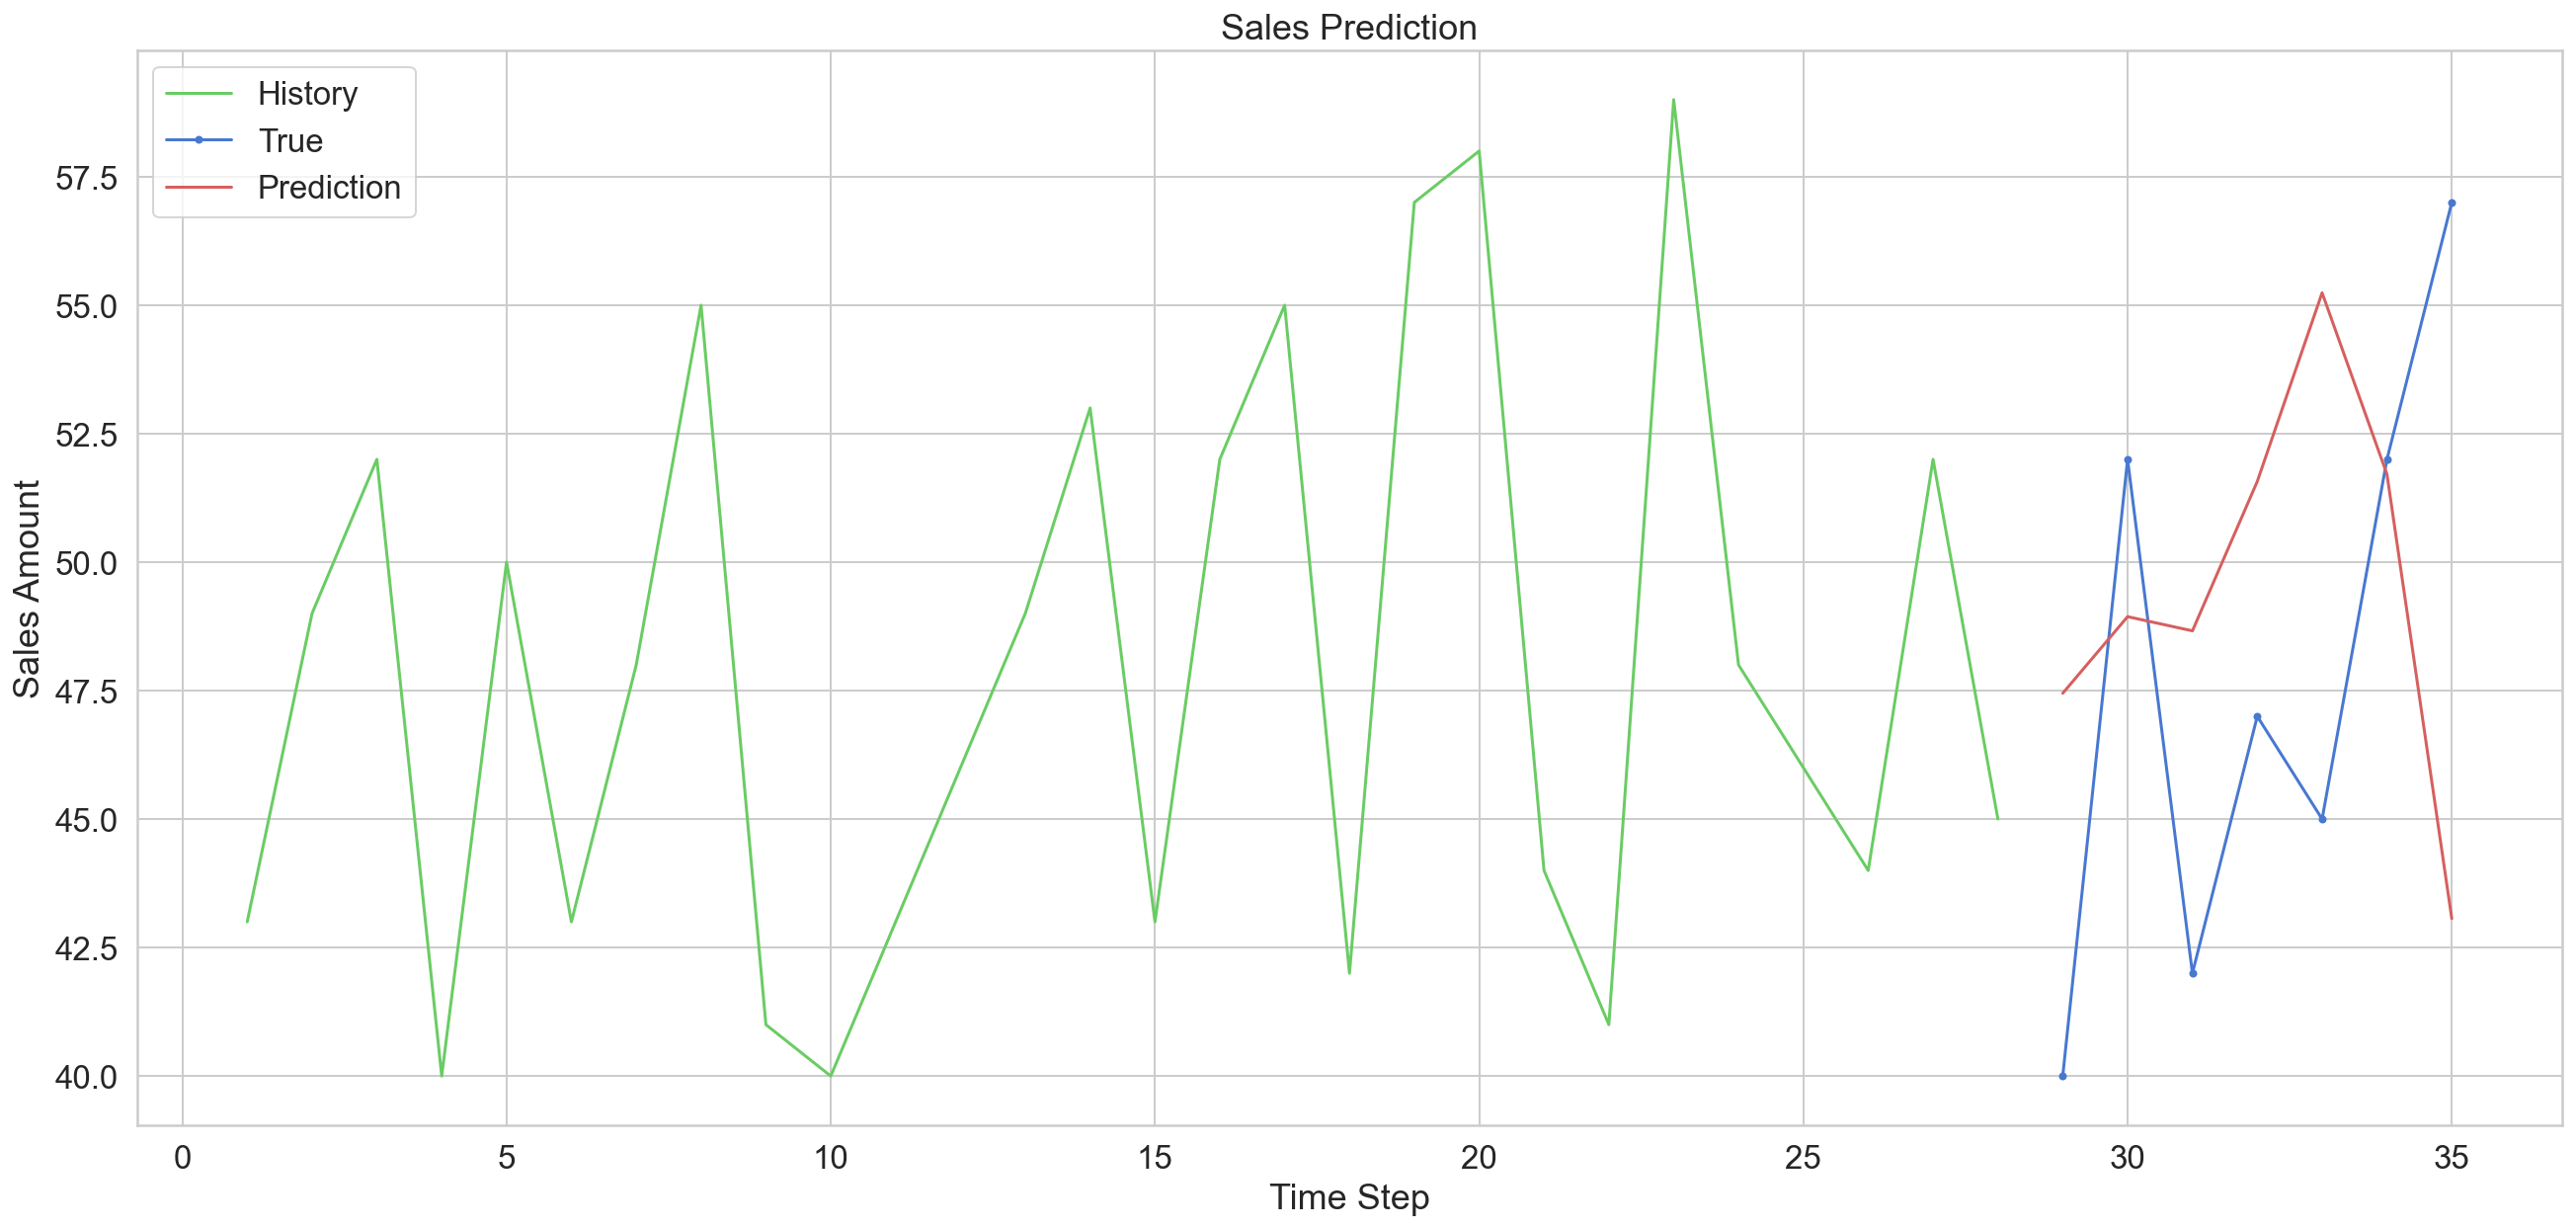

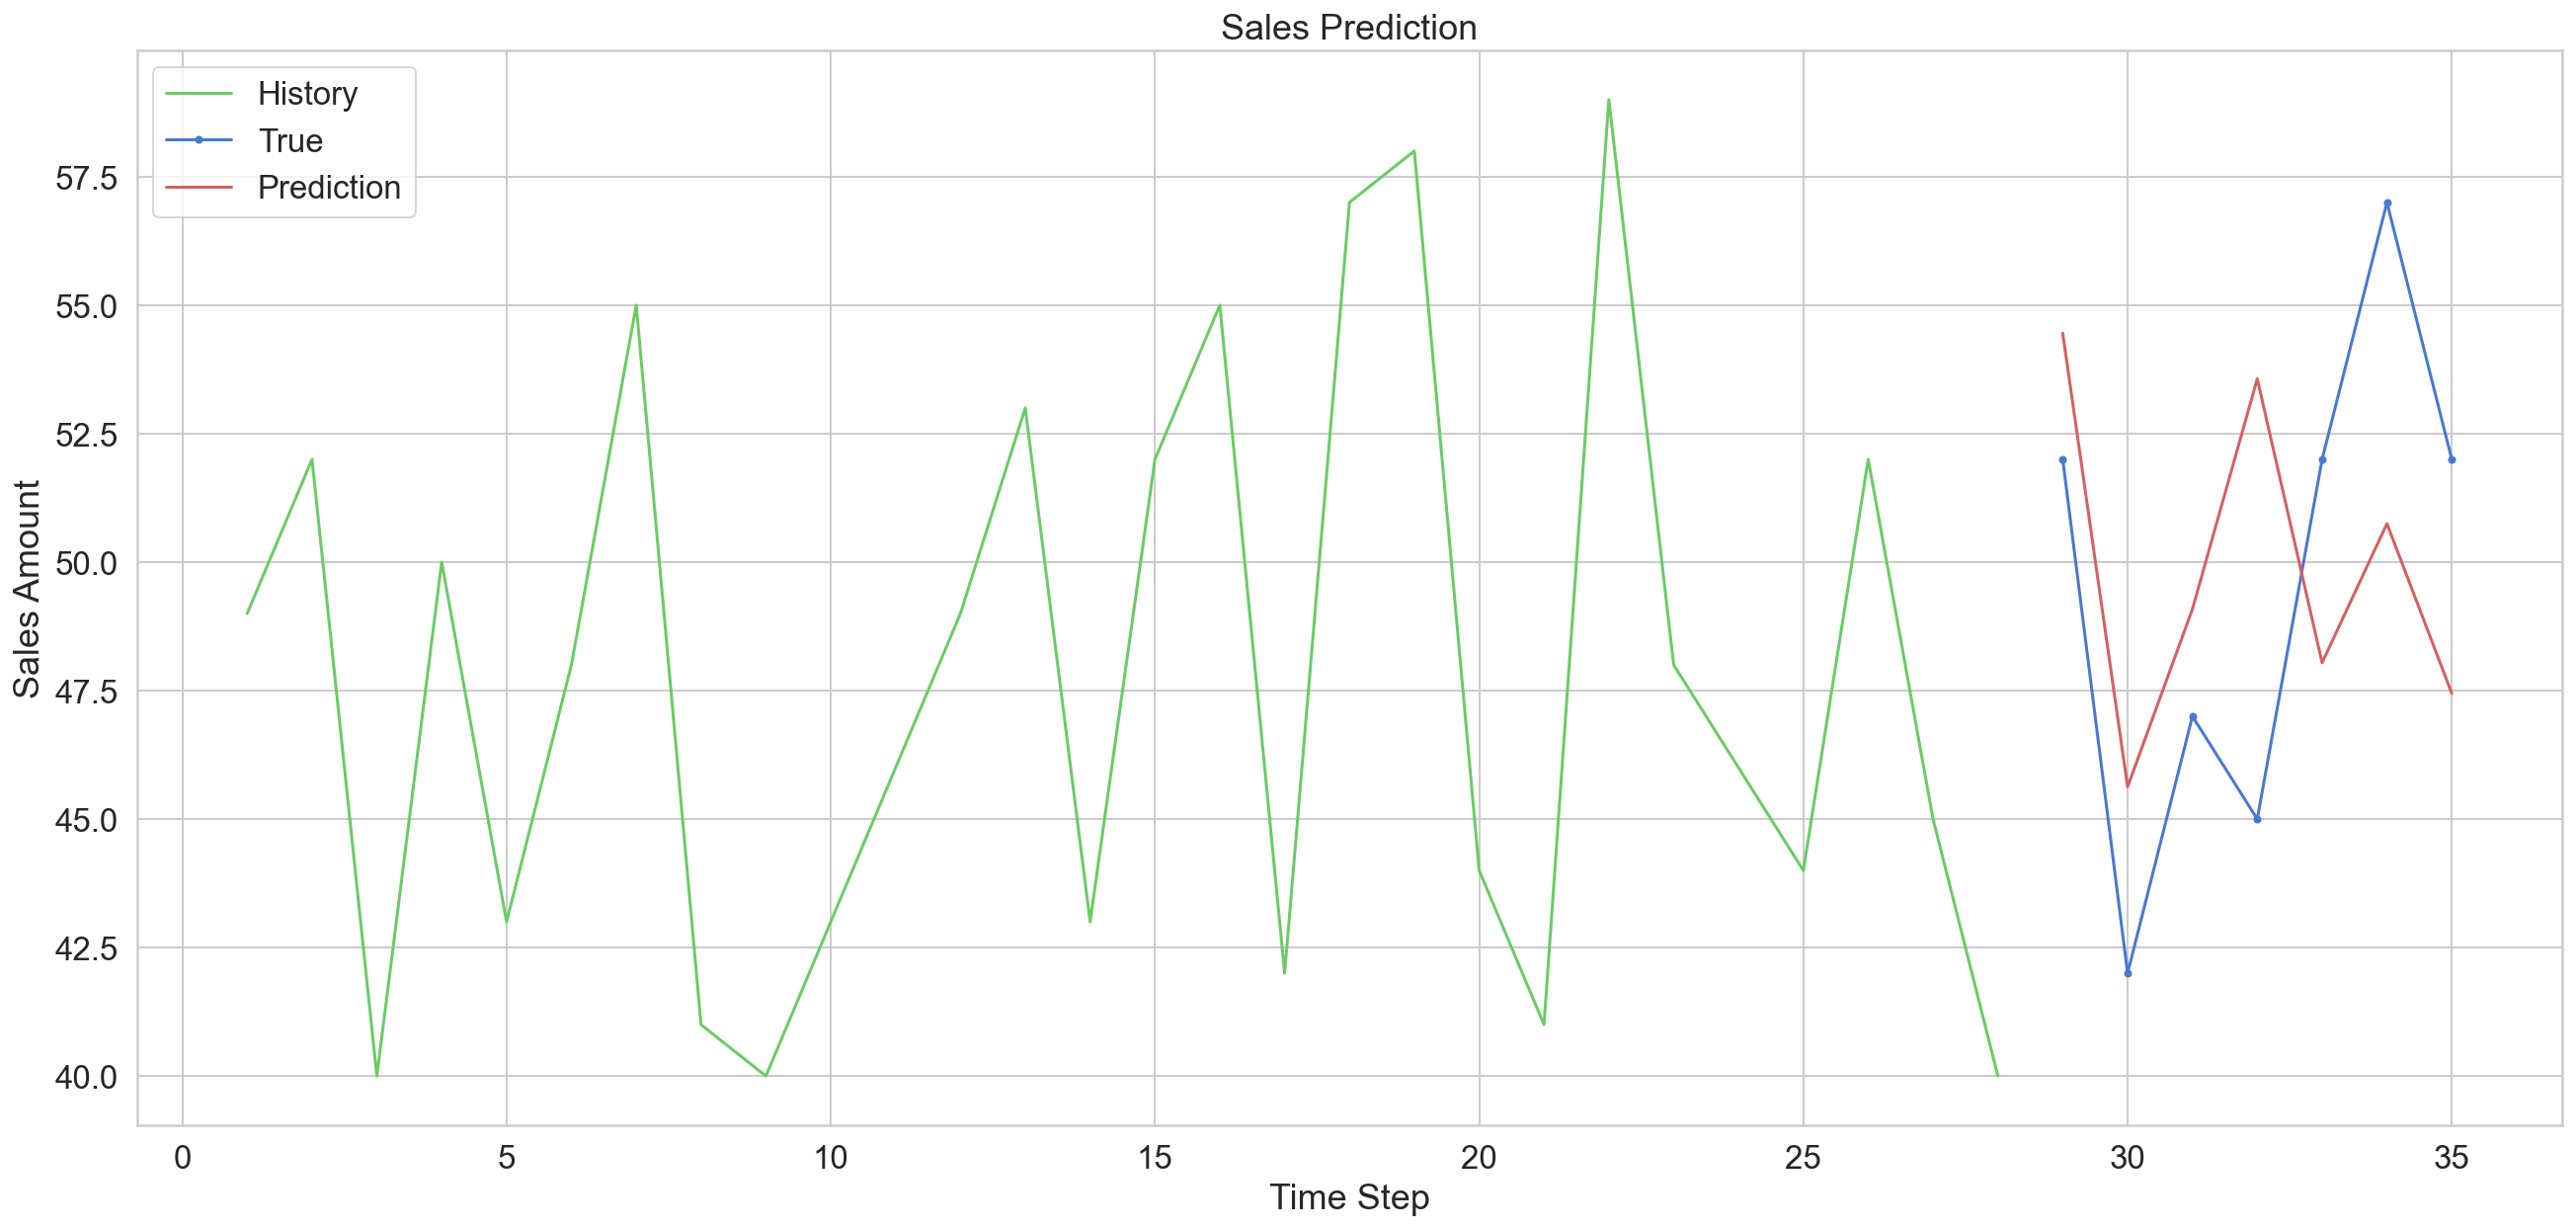

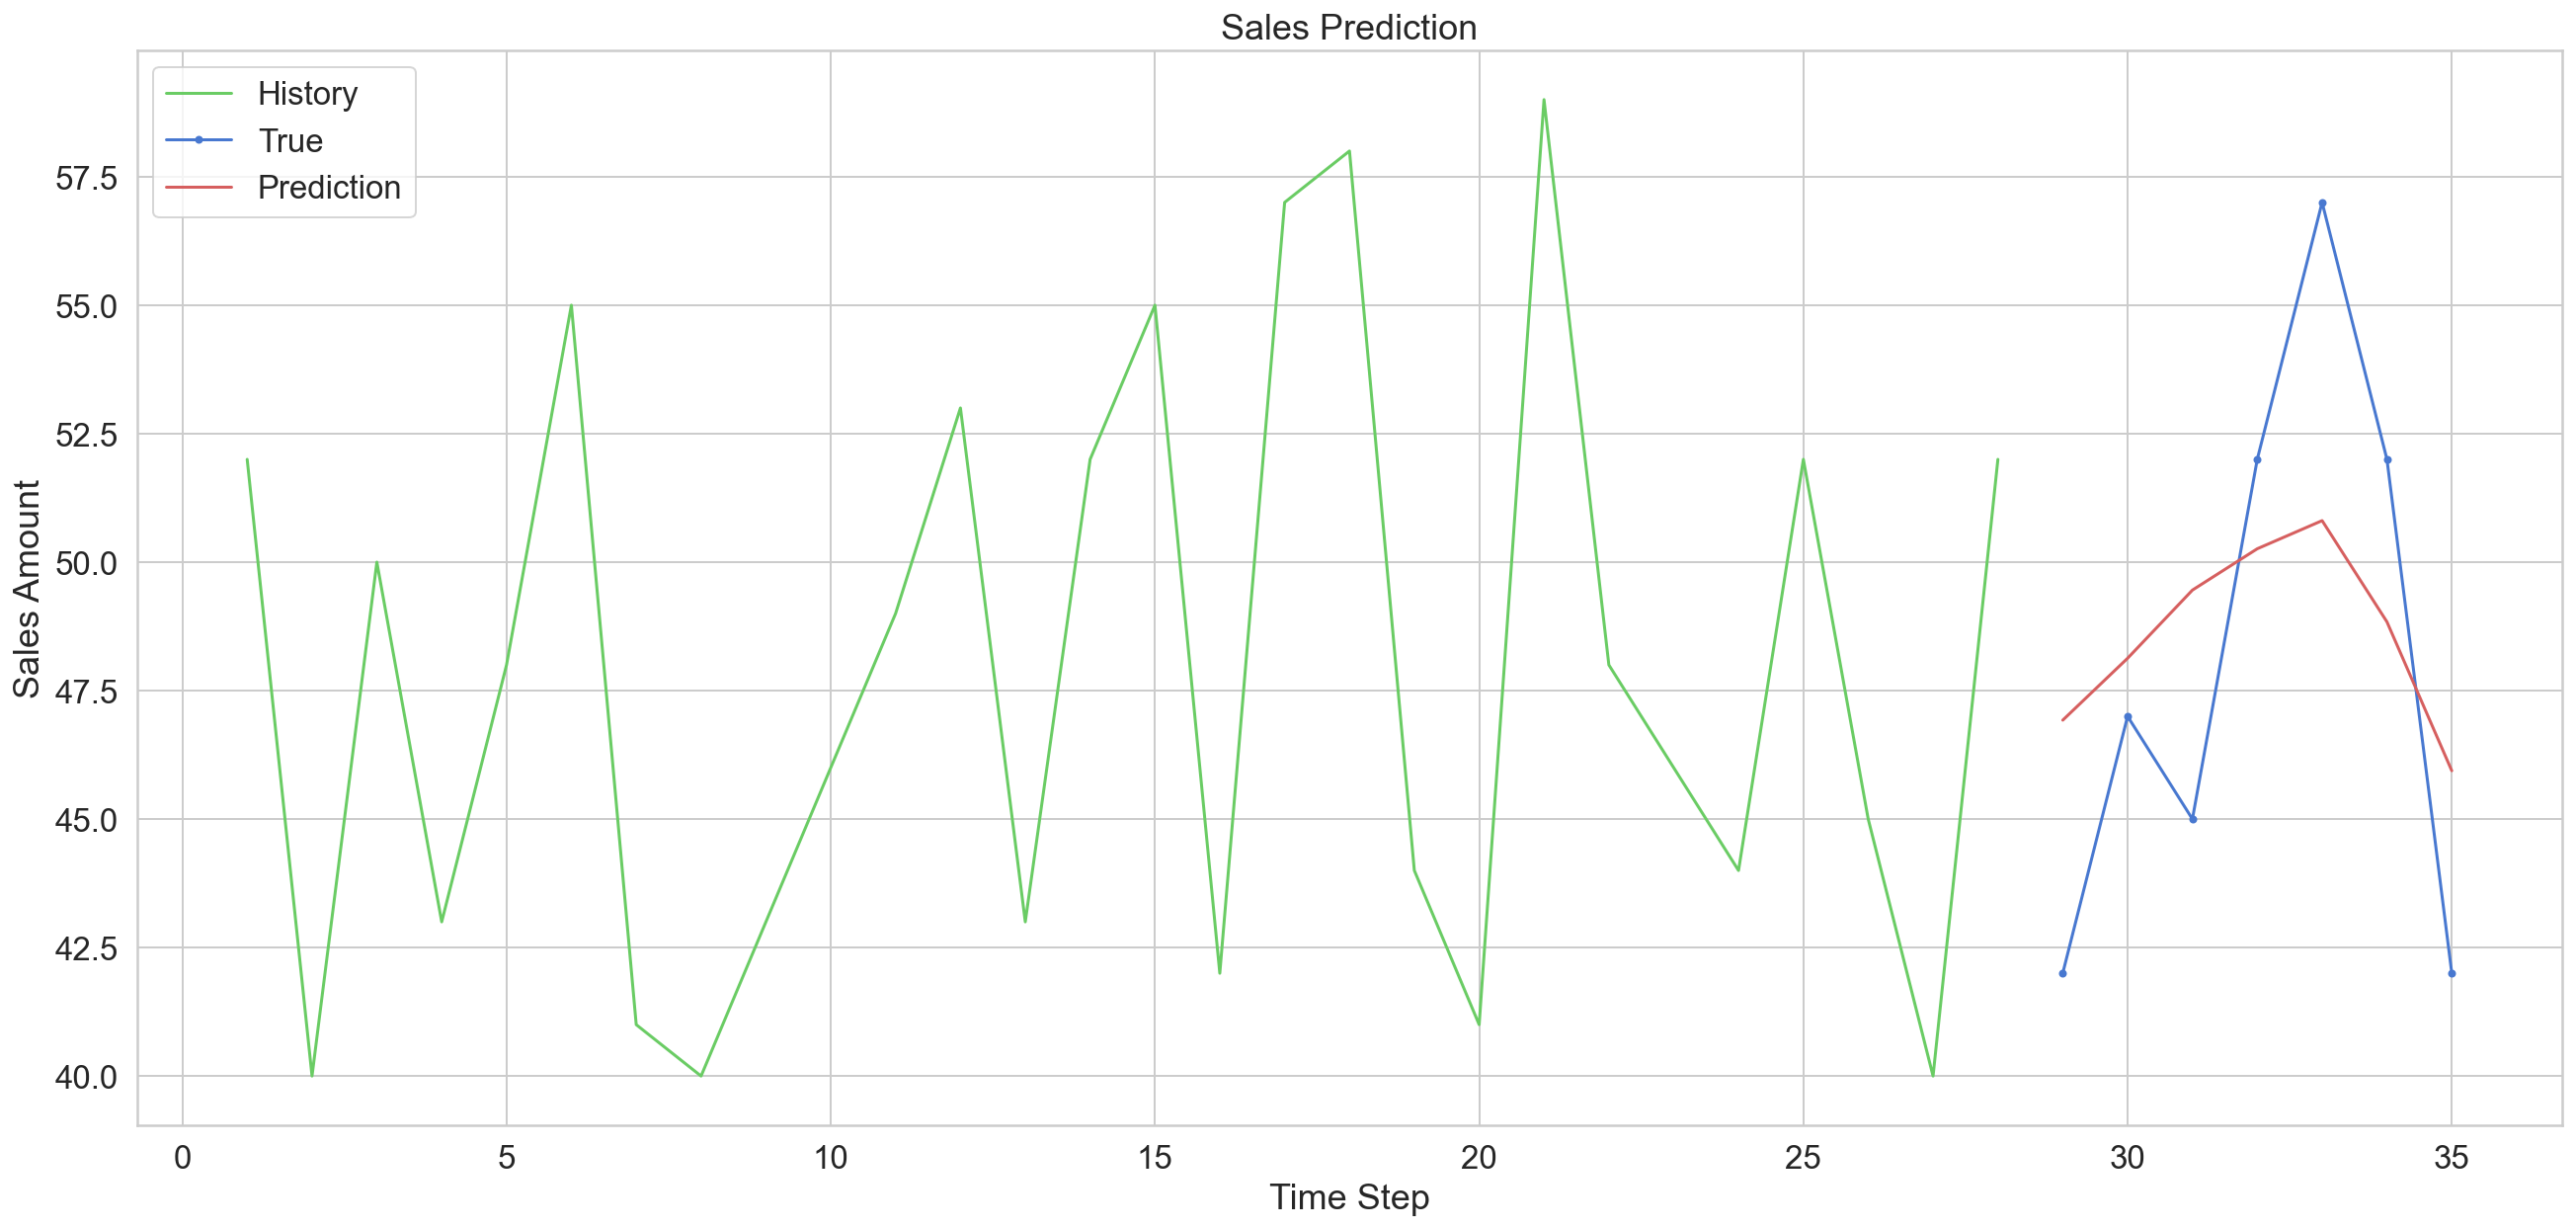

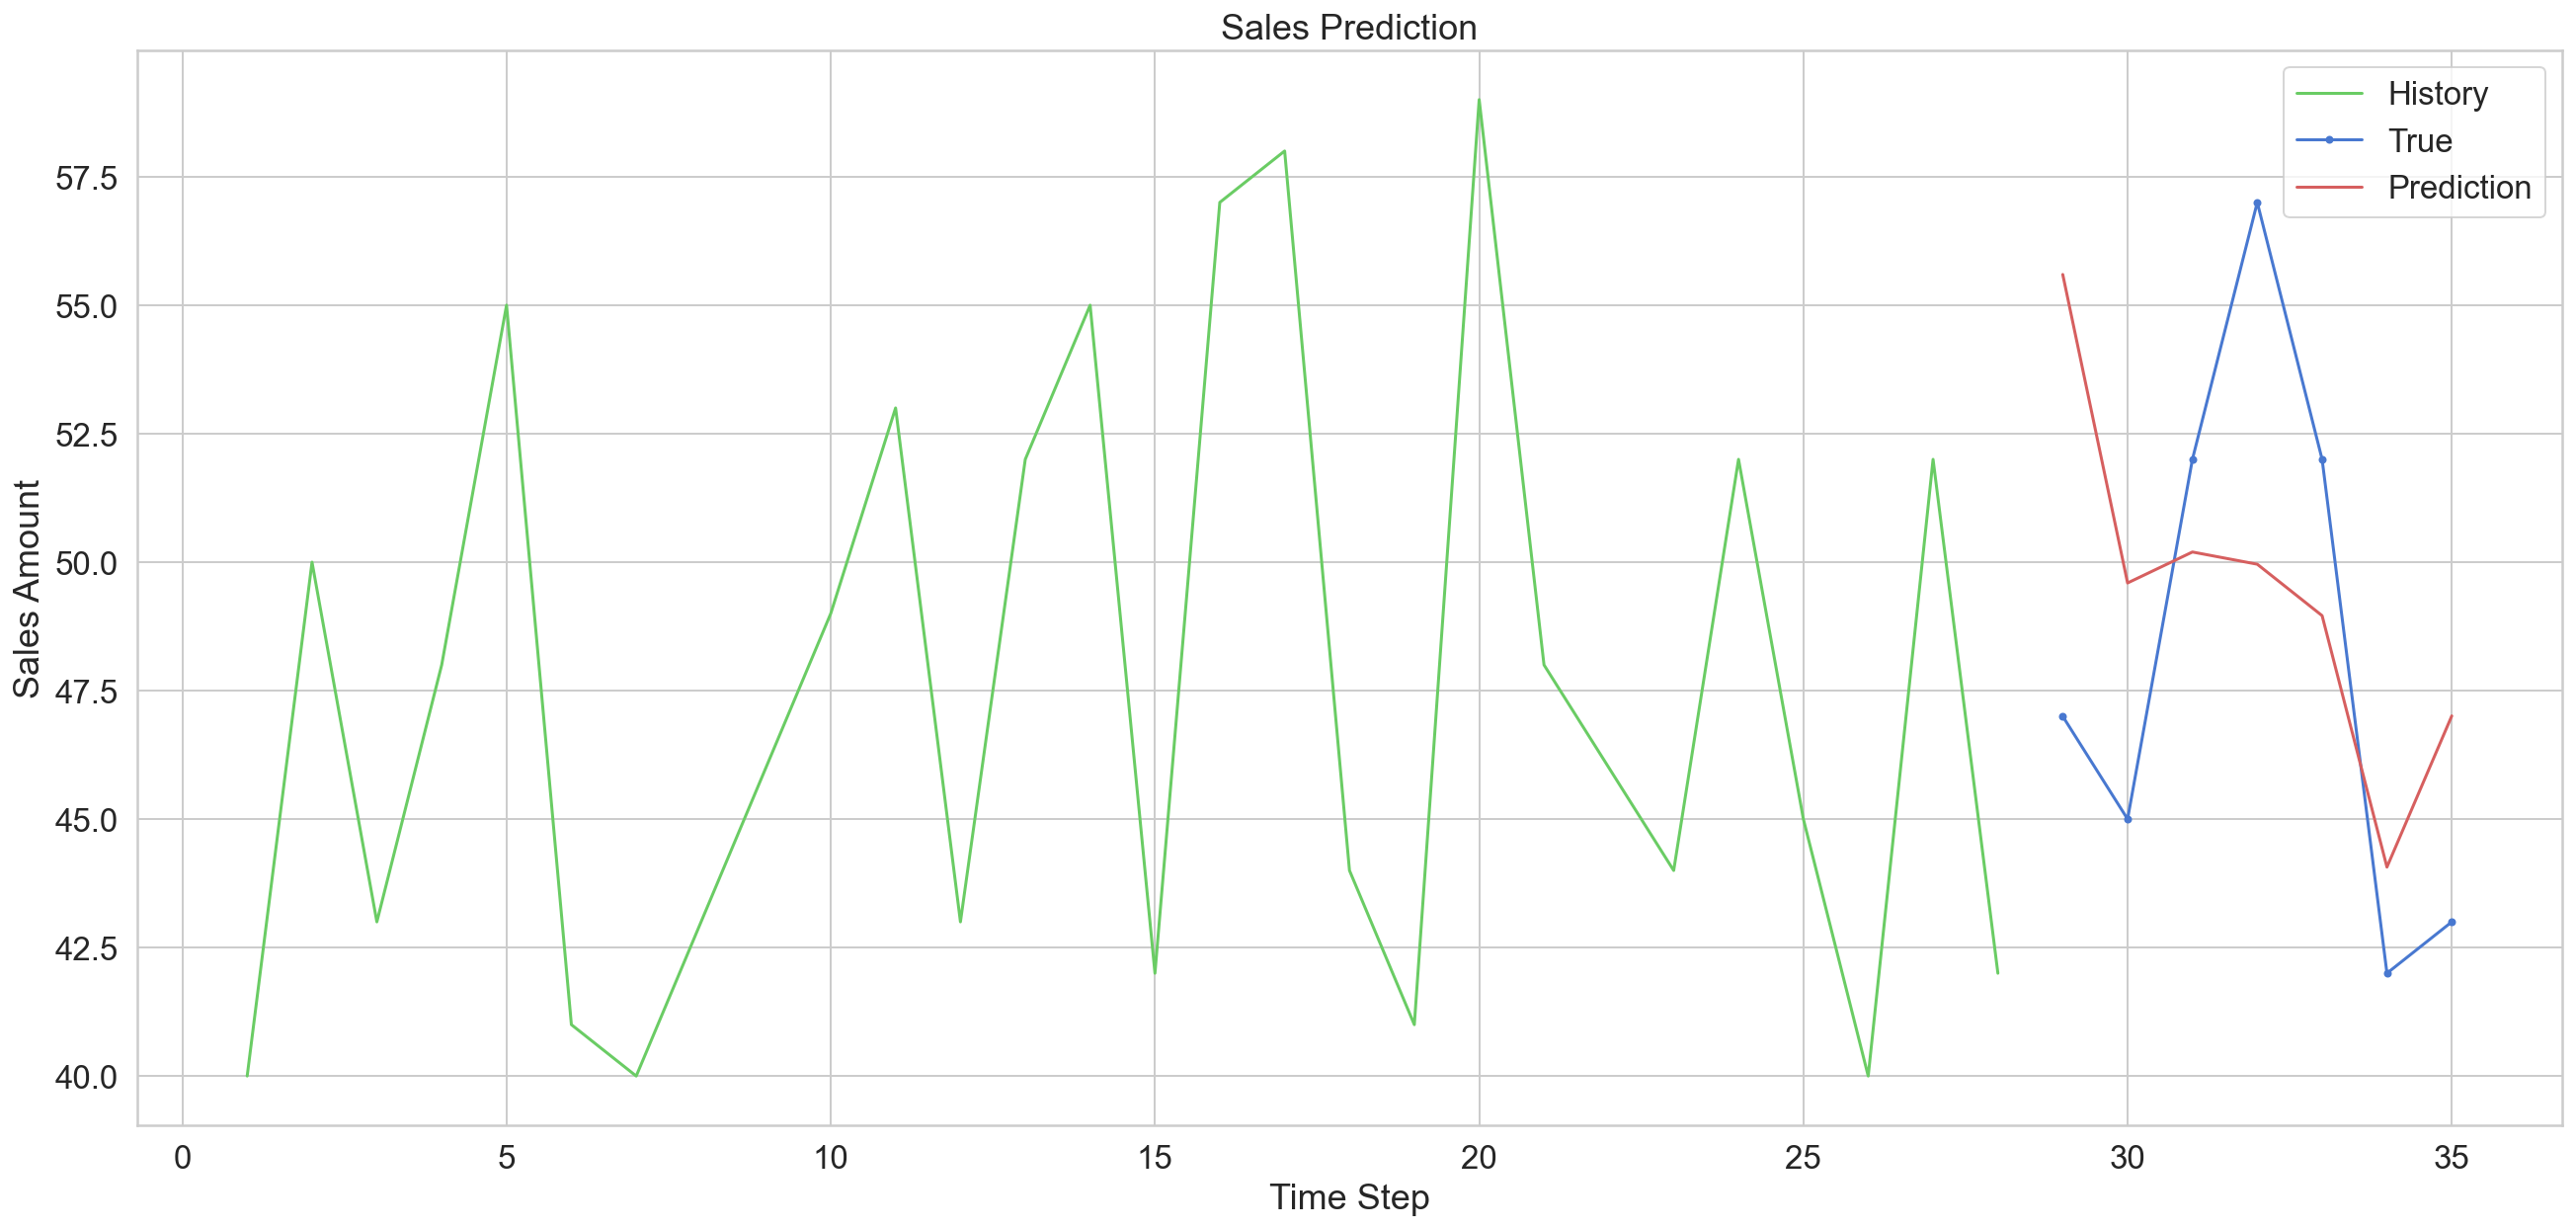

In [26]:
j=0
for i in X_test_inv:
    plt.plot( np.arange(1, len(i)+1),i[:,0], 'g', label="History")
    plt.plot(np.arange(len(i)+1, len(i)+1 + y_test_inv.shape[1]), y_test_inv[j][:,0], marker='.', label="True")
    plt.plot(np.arange(len(i)+1, len(i)+1+ y_test_inv.shape[1]), y_pred_inv[j][:,0], 'r', label="Prediction")
    plt.ylabel('Sales Amount')
    plt.xlabel('Time Step')
    plt.title('Sales Prediction')
    plt.legend()
    plt.show();
    if j==3:
        break
    j+=1

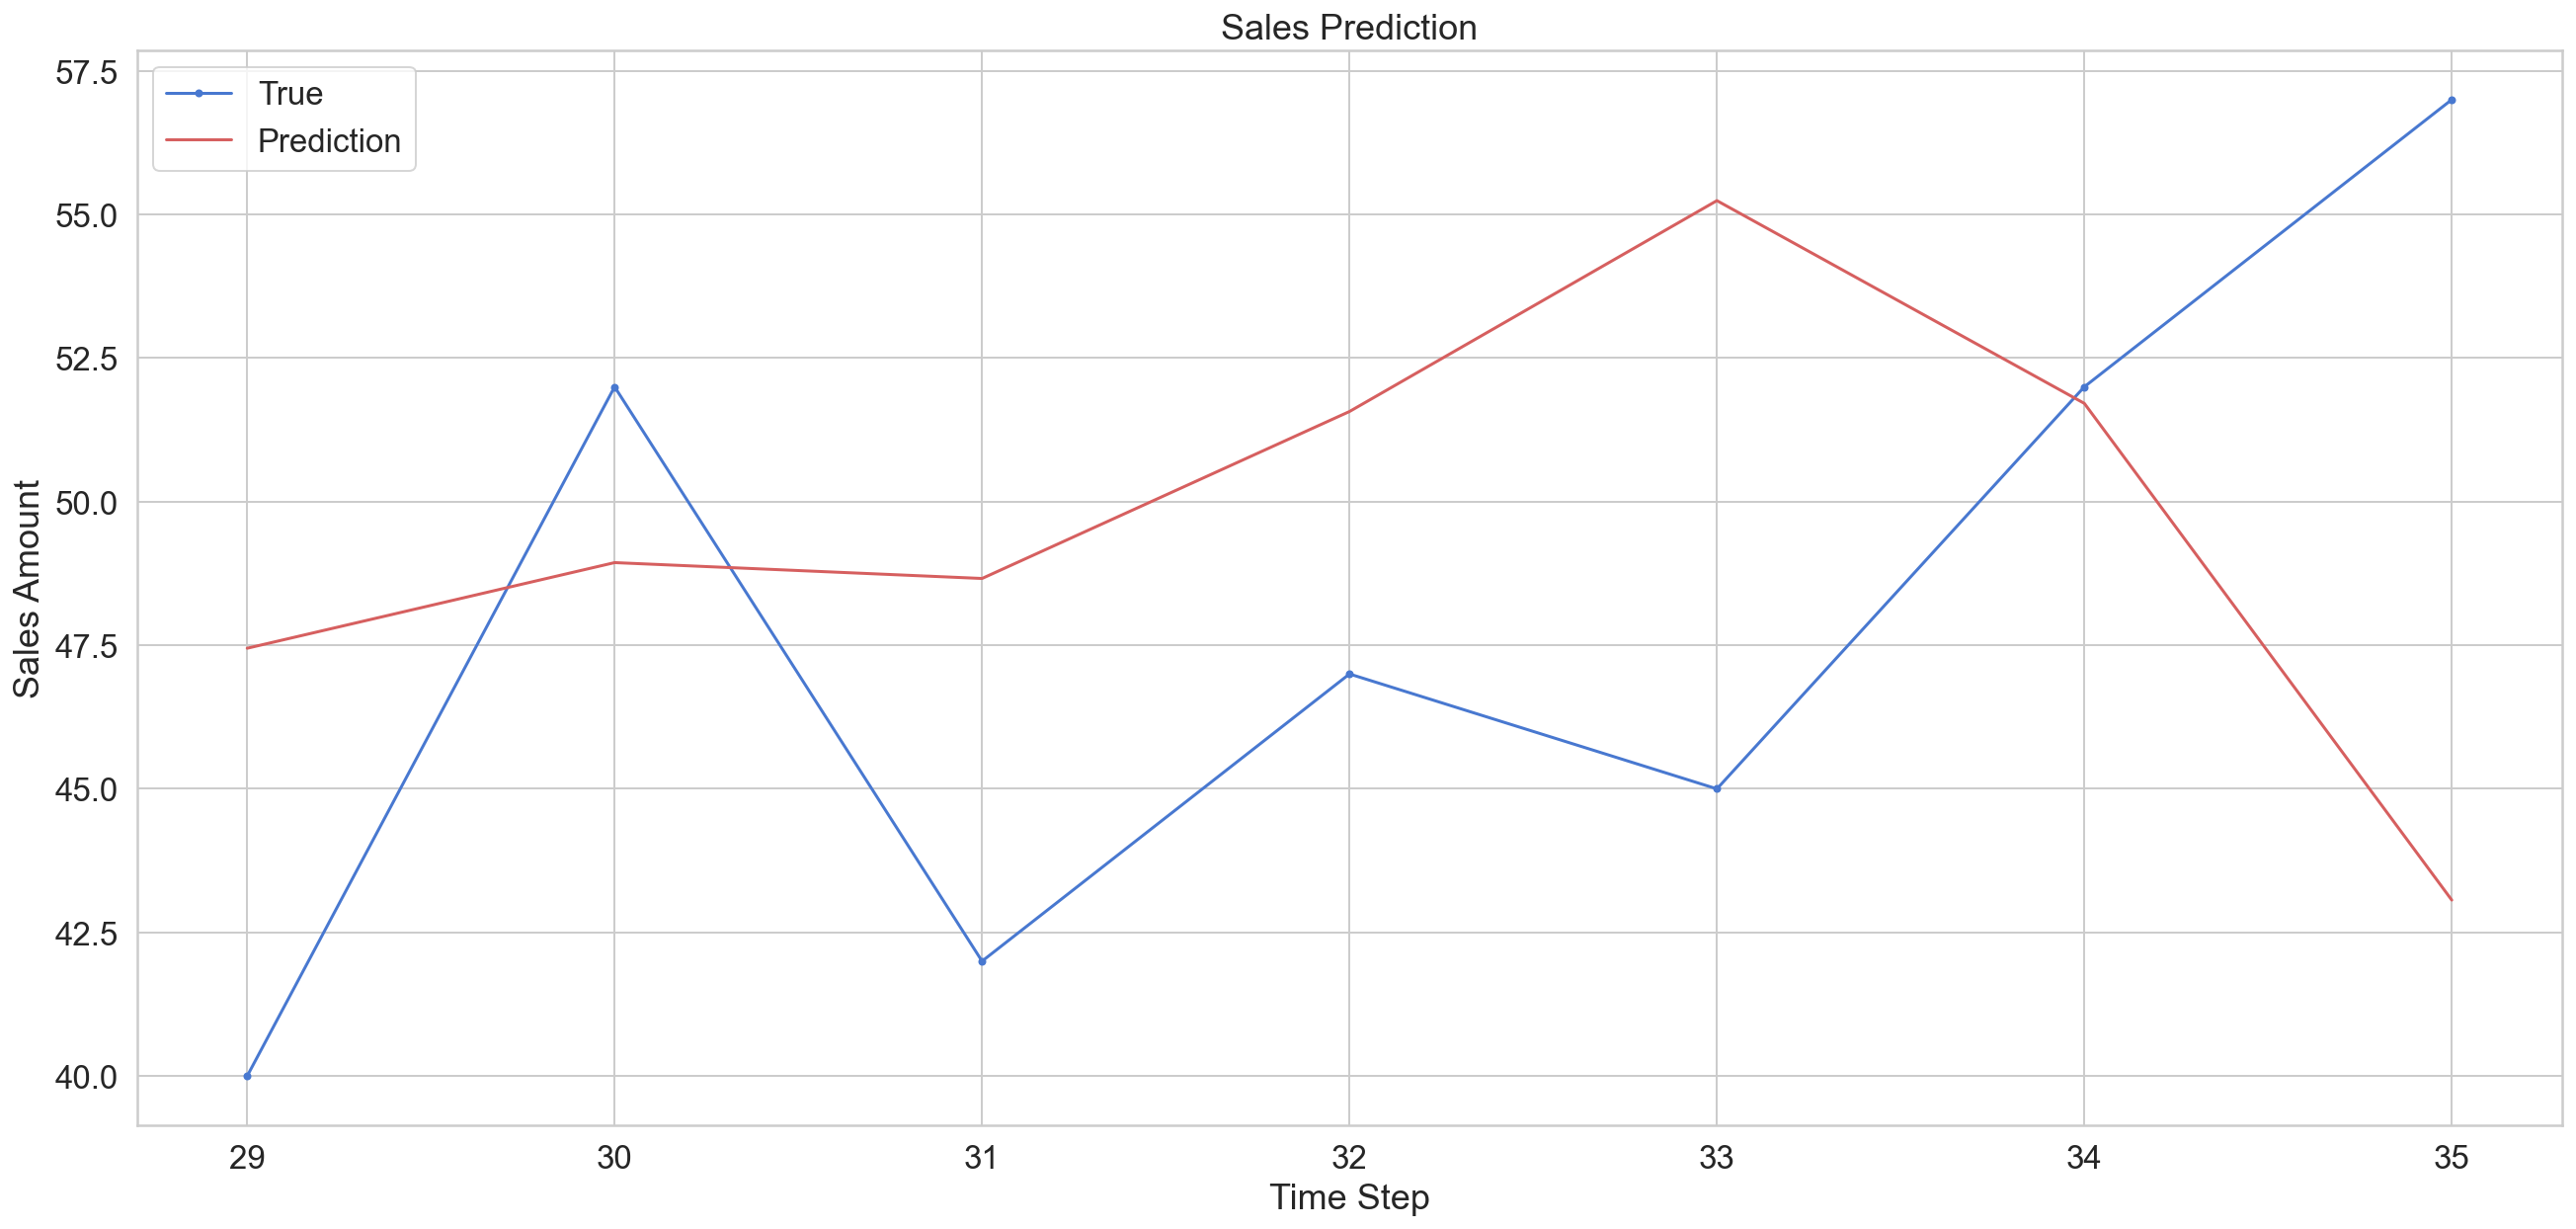

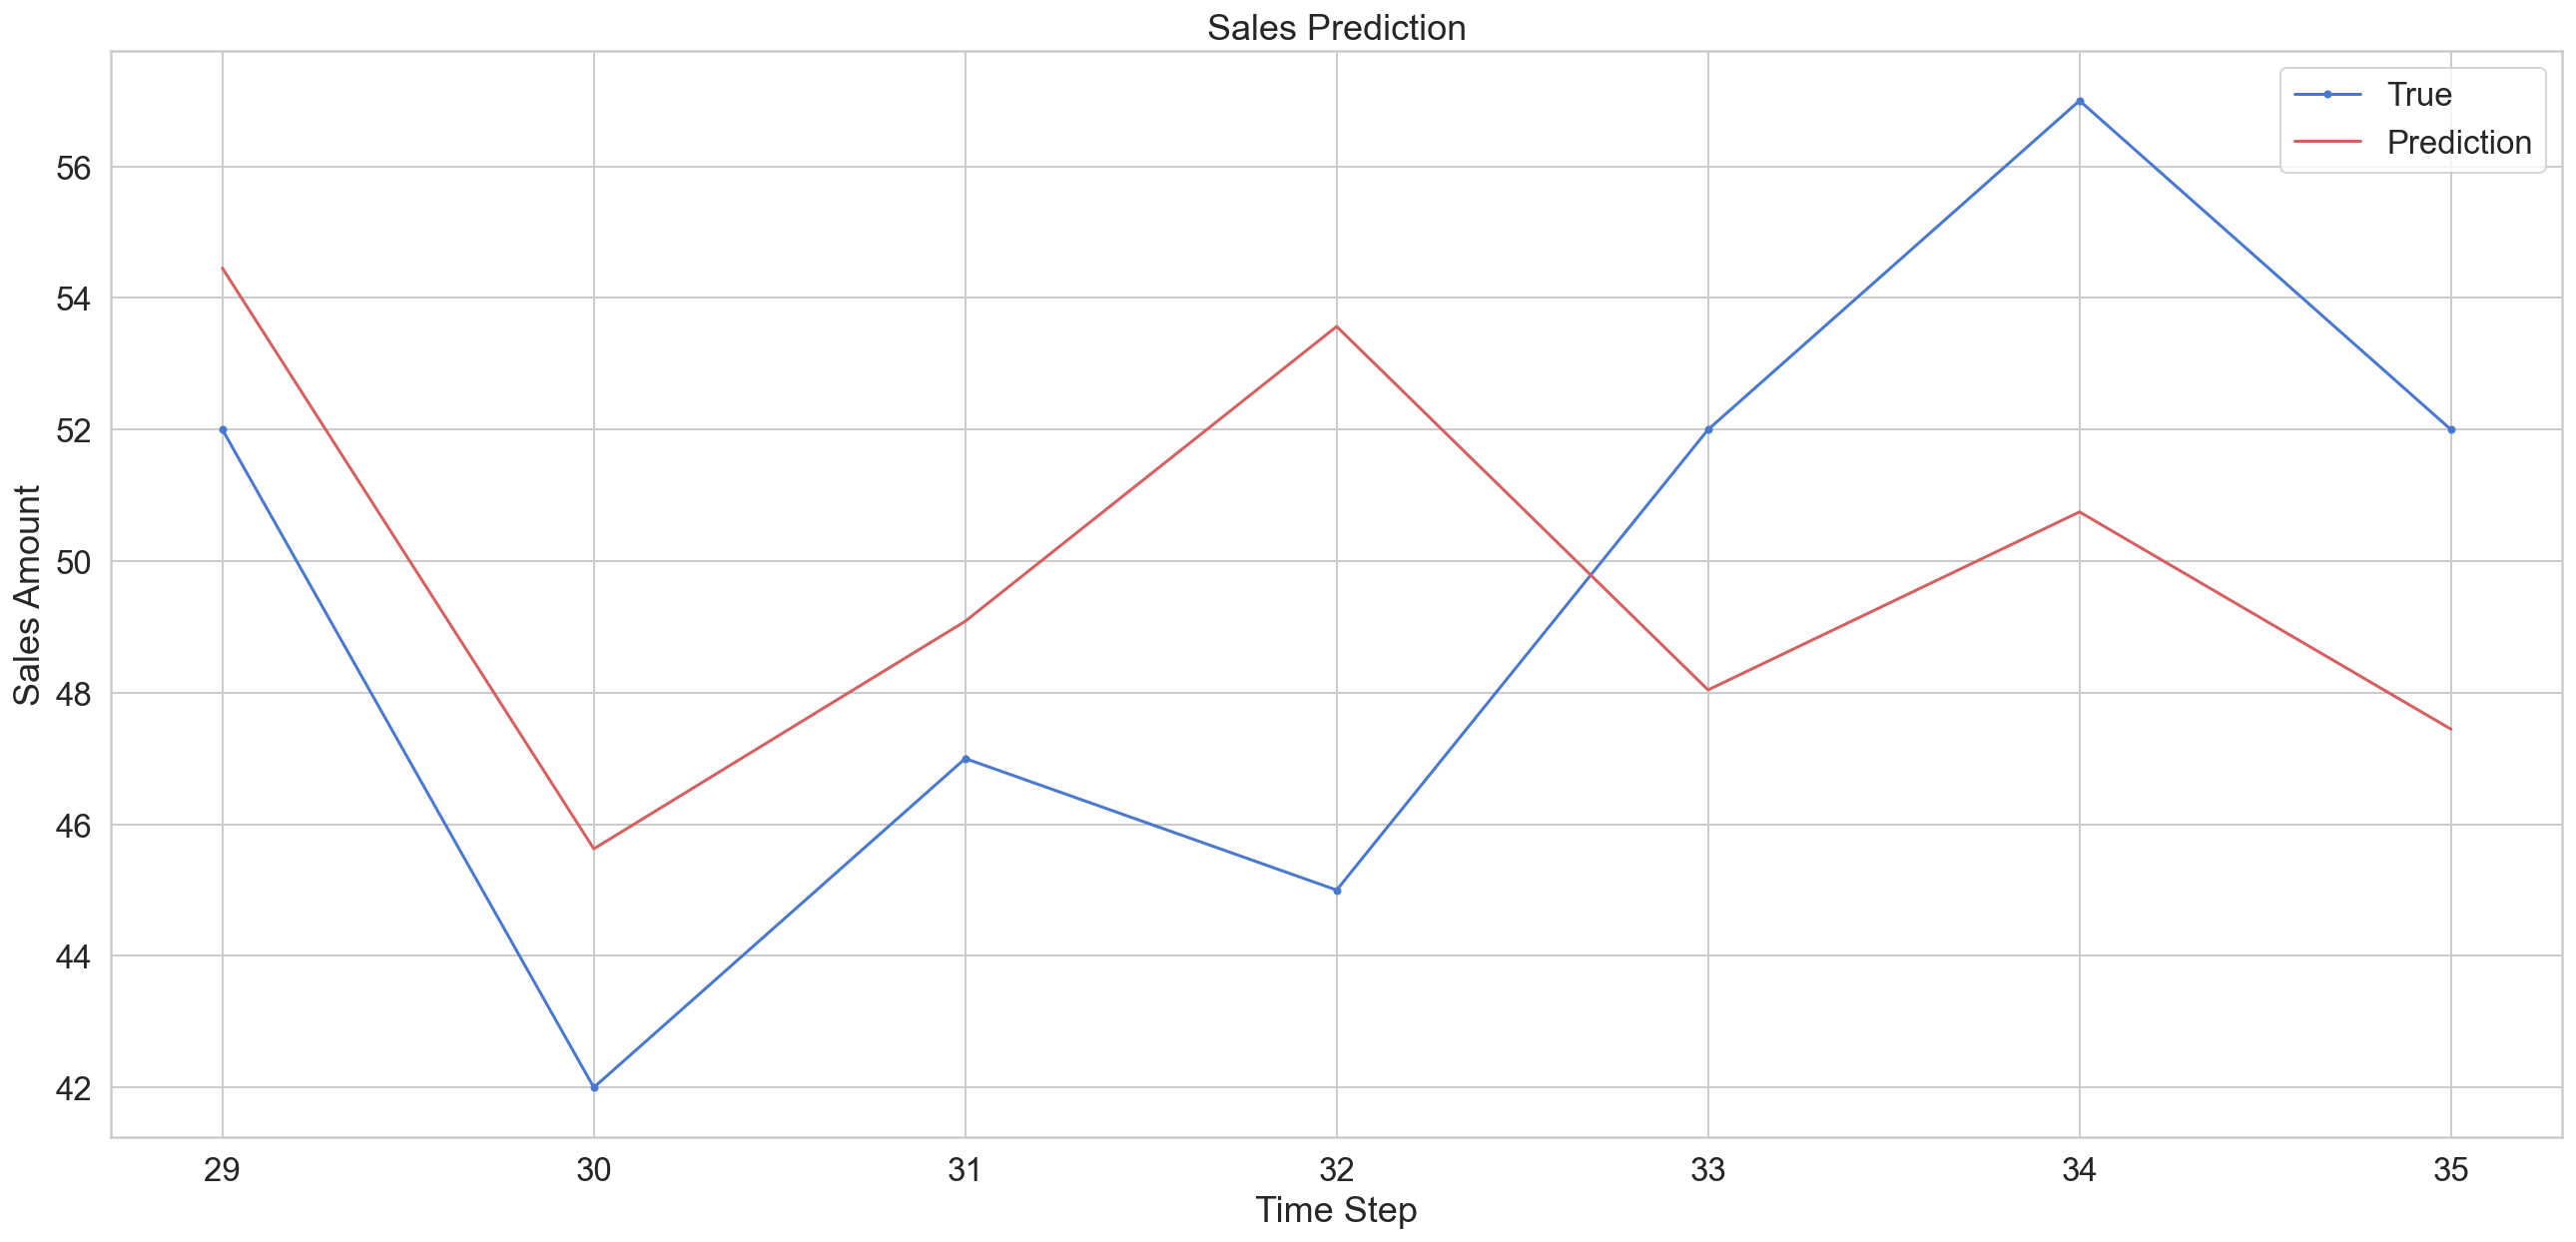

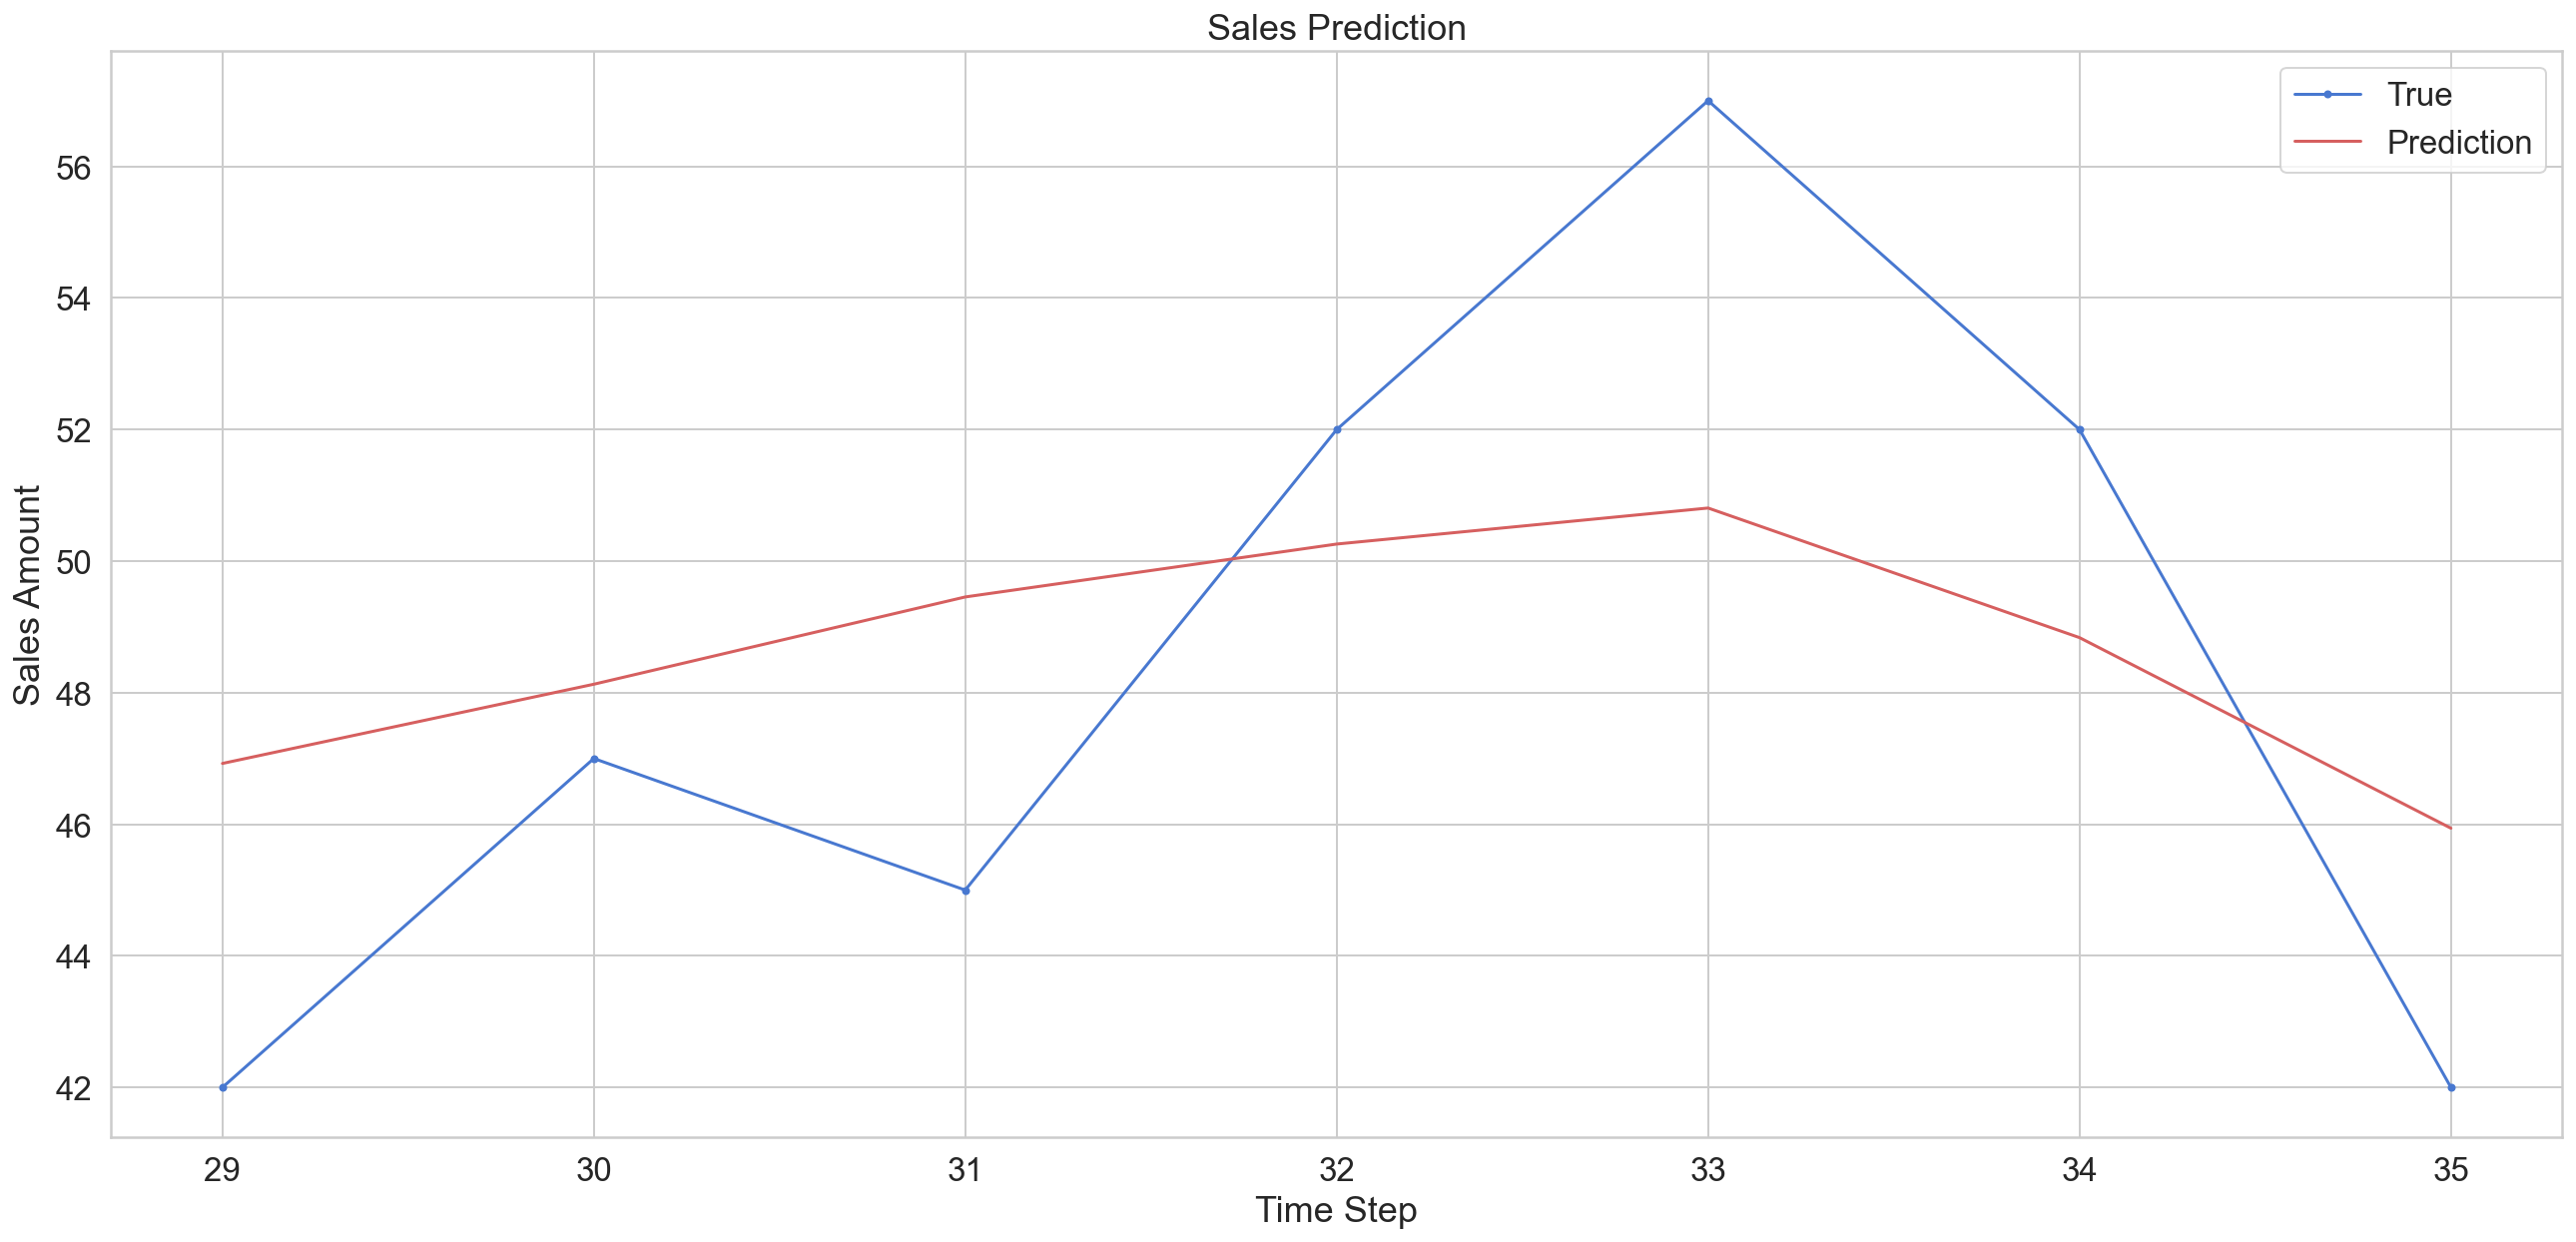

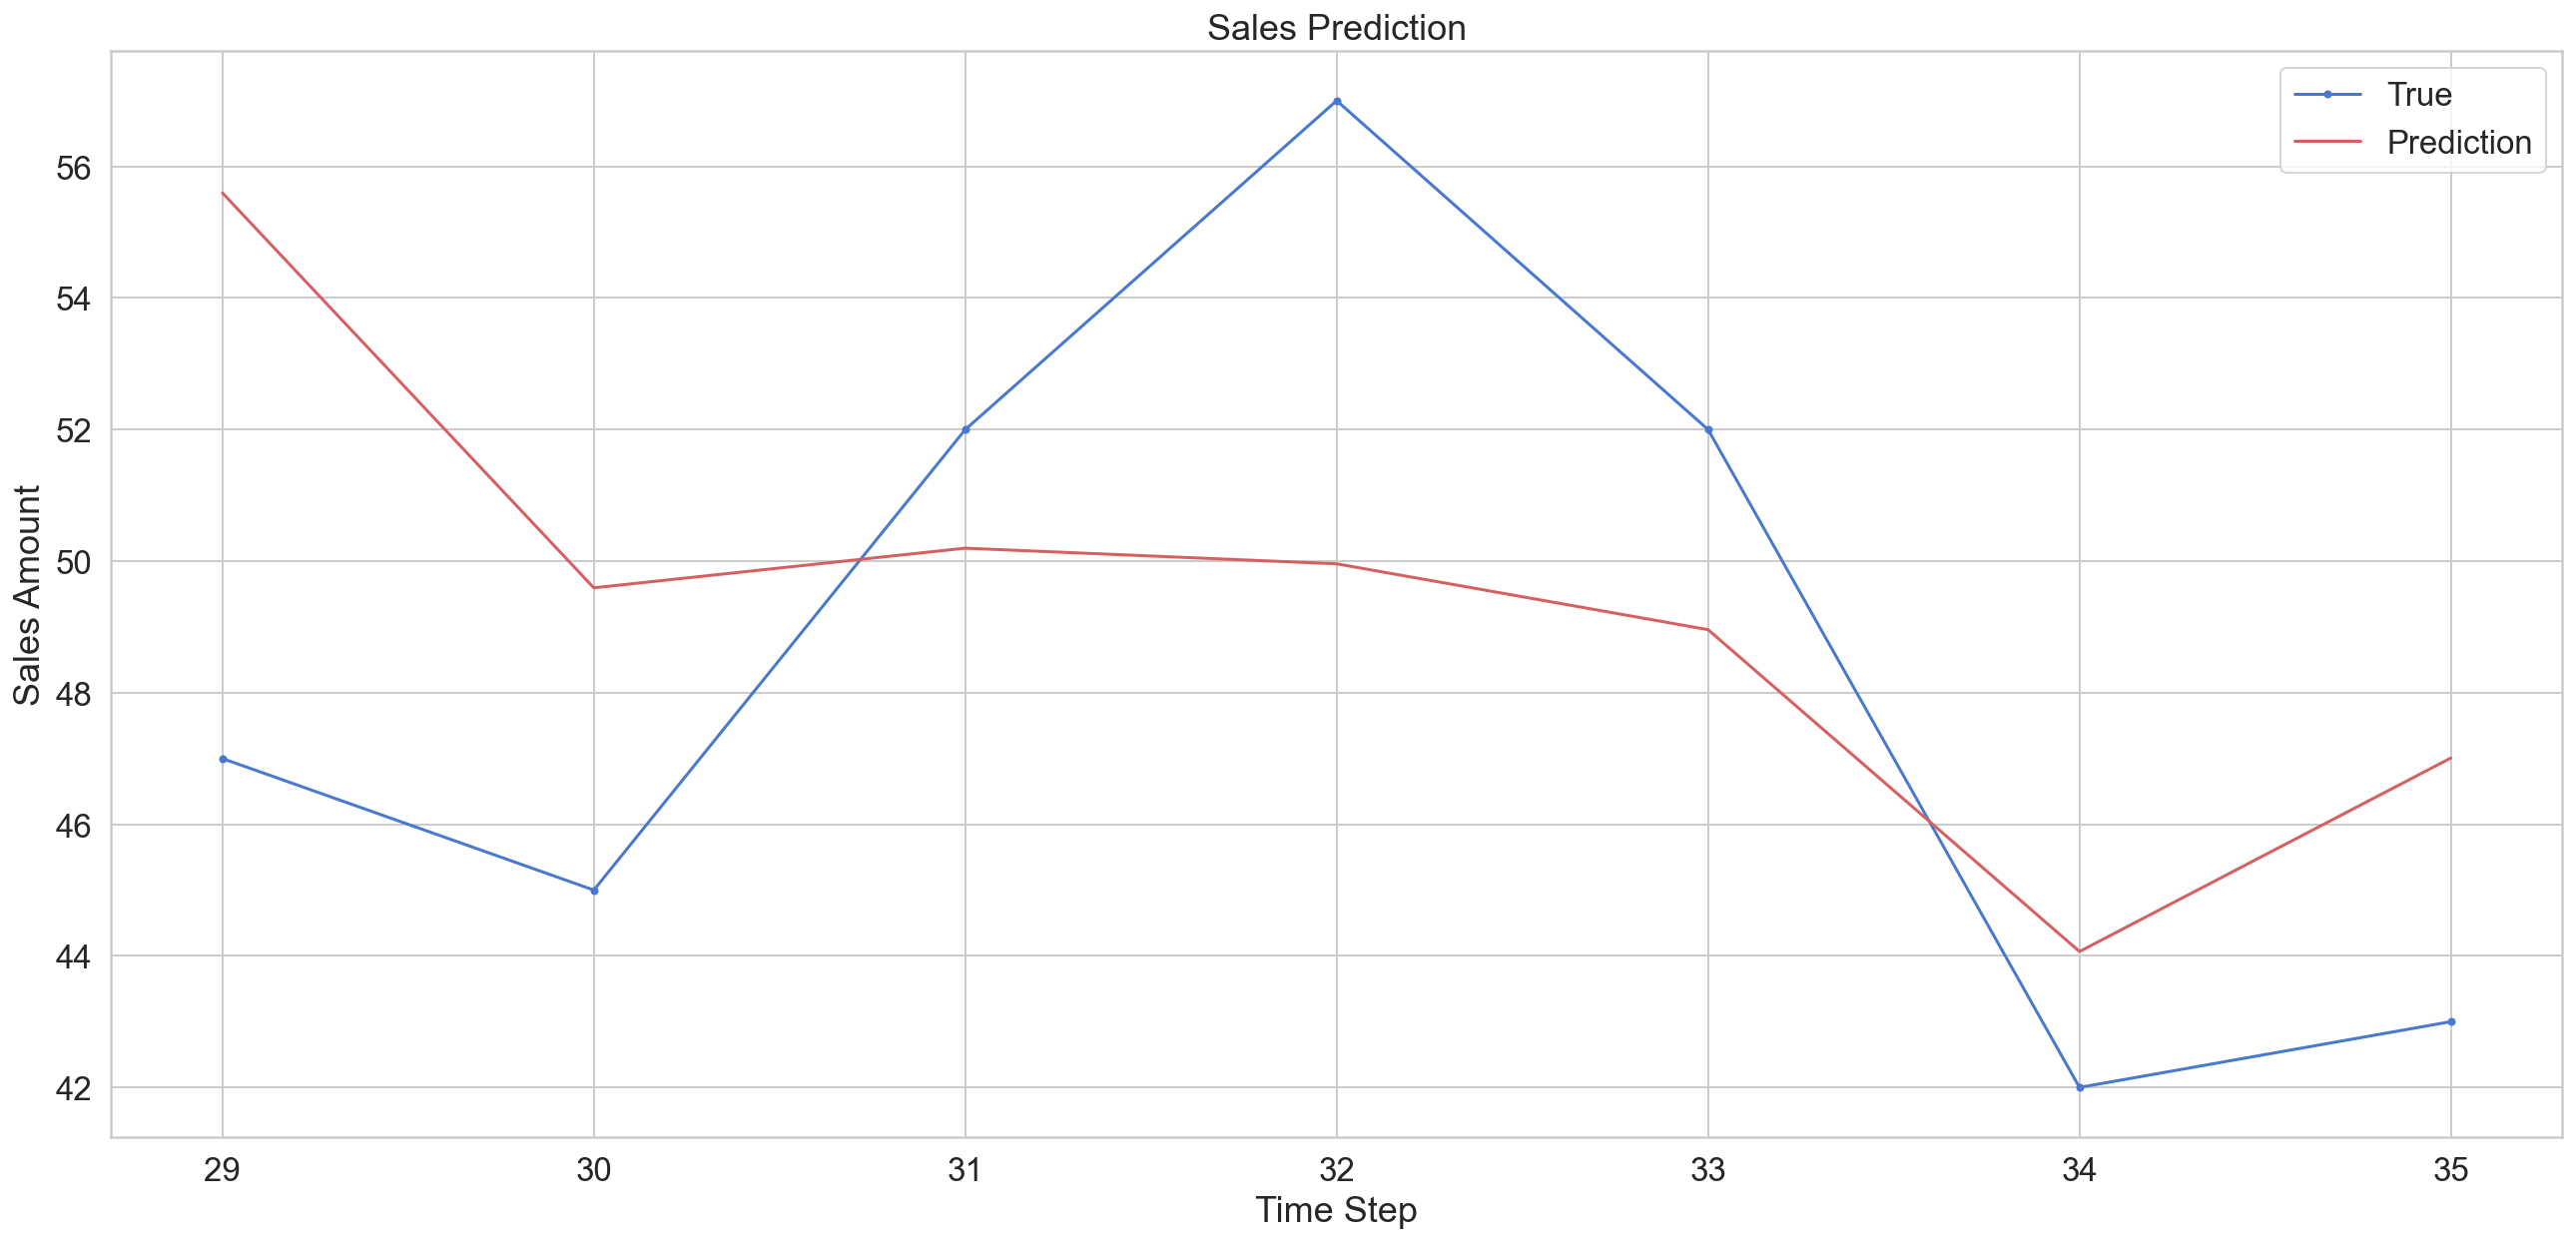

In [27]:
j=0
for i in X_test_inv:
    plt.plot(np.arange(len(i)+1, len(i)+1 + y_test_inv.shape[1]), y_test_inv[j][:,0], marker='.', label="True")
    plt.plot(np.arange(len(i)+1, len(i)+1+ y_test_inv.shape[1]), y_pred_inv[j][:,0], 'r', label="Prediction")
    plt.ylabel('Sales Amount')
    plt.xlabel('Time Step')
    plt.title('Sales Prediction')
    plt.legend()
    plt.show();
    if j==3:
        break
    j+=1

In [28]:
MSE=mean_squared_error(y_test_inv[:,0], y_pred_inv[:,0])
print(f'Mean squared error : {MSE}') 

Mean squared error : 63.78639801640428


In [29]:
model.save('SalesPredictionModel')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: SalesPredictionModel\assets
